# SOCNN Full Sequence End to End
This model takes the 150,000 rows of acoustic data, and takes the mean, standard deviation etc. of every 128 datapoints (granularity=128) to make our features. Then train a WaveNet-like dialated causal convolutional neural network on these features to predict the time remaining before a lab earthquake. This model is trained to make predictions for each time step. When we are making our test data predictions we use the average of these predictions to make a single prediction of the remaining time at the last time step.

## Import python modules

In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from threading import Thread

import os
import sys
import glob
import random
print("Imported!")

Imported!


## Set Hyperparameters/Constants
All our hyperparameters and global variables in one place.

In [7]:
model_name = 'dcnn-full-sequence-end-to-end'
total_size = 629_145_480
seg_size = 150_000
bin_size = 2**12 # data comes in bins of 2^12 contiguous rows (ADC with 12-bit resolution)
bins_per_seg = (seg_size + bin_size - 1) // bin_size # ceil(seg_size / bin_size)
case_size = bins_per_seg * bin_size
target_size = 40
granularity = 128
seq_size = (seg_size + granularity -1) // granularity

epochs = 2 #16 * bins_per_seg
batch_size = 2**3
feature_size = 2
valid_steps = 100
learning_rate = 0.0008

total_cases = total_size // case_size
total_batches = (total_cases + batch_size - 1) // batch_size

withheld_cases = 2**8
withheld_batches = (withheld_cases + batch_size - 1) // batch_size
withheld_size = withheld_cases * case_size
withheld_percent = 100 * withheld_size / total_size

valid_cases = valid_steps * batch_size
valid_batches = valid_cases // batch_size
valid_size = valid_cases * case_size
valid_percent = 100 * valid_size / total_size

train_size = total_size - valid_size - withheld_size
train_cases = total_cases - valid_cases - withheld_cases
train_batches = train_cases // batch_size
train_percent = 100 * train_size / total_size


print("----- Hyperparameters -----")
print("epochs:", epochs)
print("batch_size:", batch_size)
print("feature_size:", feature_size)
print("valid_steps:", valid_steps)
print("learning_rate:", learning_rate)
print("---------------------------")
print("seg_size:", seg_size)
print("bin_size:", bin_size)
print("bins_per_seg:", bins_per_seg)
print("case_size:", case_size)
print("target_size:", target_size)
print("granularity:", granularity)
print("seq_size:", seq_size)
print("total_cases:", total_cases)
print("total_batches:", total_batches)
print("withheld_cases:", withheld_cases)
print("withheld_batches:", withheld_batches)
print("valid_cases:", valid_cases)
print("valid_batches:", valid_batches)
print("train_cases:", train_cases)
print("train_batches:", train_batches)
print("---------------------------")
print("total_size:       {0:9d}".format(total_size))
print("withheld_size:    {0:9d}".format(withheld_size))
print("train_size:       {0:9d}".format(train_size))
print("valid_size:       {0:9d}".format(valid_size))
print("---------------------------")
print("withheld_percent: {0:8.2f}%".format(withheld_percent))
print("valid_percent:    {0:8.2f}%".format(valid_percent))
print("train_percent:    {0:8.2f}%".format(train_percent))
print("---------------------------")
print("model_name:", model_name)
print("---------------------------")

----- Hyperparameters -----
epochs: 2
batch_size: 8
feature_size: 2
valid_steps: 100
learning_rate: 0.0008
---------------------------
seg_size: 150000
bin_size: 4096
bins_per_seg: 37
case_size: 151552
target_size: 40
granularity: 128
seq_size: 1172
total_cases: 4151
total_batches: 519
withheld_cases: 256
withheld_batches: 32
valid_cases: 800
valid_batches: 100
train_cases: 3095
train_batches: 386
---------------------------
total_size:       629145480
withheld_size:     38797312
train_size:       469106568
valid_size:       121241600
---------------------------
withheld_percent:     6.17%
valid_percent:       19.27%
train_percent:       74.56%
---------------------------
model_name: dcnn-full-sequence-end-to-end
---------------------------


## Load data
This takes a while to load the data into memory but it only needs to be run once every jupyter notebook session.

In [4]:
print("Reading data...")
data = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.float32, 'time_to_failure': np.float32})[:-withheld_size]
print("Done reading data!")

Reading data...
Done reading data!


## Data Augmentation/Feature Engineering
Here we do our feature engineering and define our batch generator.

In [8]:
# A vector with 1's marking the end of a bin
bin_gap = 1.095496e-03 # https://www.kaggle.com/allunia/shaking-earth
row_gap = 1.100000e-09
bin_end = np.full((1, bin_size), row_gap, dtype=np.float32)
bin_end[0,0] = bin_gap

def create_features(df):
    gran_mean = (df.mean(axis=1) - 4.47) / 1.5
    gran_median = (np.median(np.abs(df), axis=1) - 4.5) / 1.5
    gran_std = (df.std(axis=1) - 4.26) / 9.7
    gran_max = (df.max(axis=1) - 13.83) / 19.0
    gran_min = (df.min(axis=1) + 4.83) / 18.6
    return np.c_[gran_mean, gran_median, gran_std, gran_max, gran_min]

def augment_data(df):
    x = df.acoustic_data.values
    x = np.expand_dims(x, axis=1)
    bin_end_resized = np.resize(bin_end, (x.shape[0],1))
    x = np.concatenate((x, bin_end_resized), axis=1)
    return x

def batch_gen(validation=False):
    while True:
        shifts = [0] if validation else [0,18,9,27,4,22,13,31,6,24,15,33,2,20,11,29,17,35,7,25,1,19,10,28,3,21,12,30,5,23,14,32,8,26,16,34,36]
#         shifts = [0,18,9,27,4,22,13,31,6,24,15,33,2,20,11,29,17,35,7,25,1,19,10,28,3,21,12,30,5,23,14,32,8,26,16,34,36]
        for shift in shifts:
            batches = valid_steps if validation else train_batches
            cases = valid_steps * batch_size if validation else train_cases
            cases_start = train_cases if validation else 0
            cases_end = cases_start + valid_cases if validation else train_cases
            case_idxs = random.sample(list(range(cases_start, cases_end)), cases)
            
            for batch in range(batches):
                start_case = batch * batch_size
                end_case = start_case + batch_size
                samples = []
                targets = []
                for i, case in enumerate(case_idxs[start_case:end_case]):
                    start_row = case * case_size + shift * bin_size
                    end_row = start_row + seg_size
                    seg = data[start_row:end_row]
                    if seg.shape[0] == seg_size:
                        features = augment_data(seg)
                        samples.append(features)
                        y = np.expand_dims(seg.time_to_failure.values, axis=1)
                        targets.append(y)
                yield np.asarray(samples), np.asarray(targets)

## Custom Metrics
Add some custom metrics to monitor our model. 
- `last_mae` is the mean absolute error of the last prediction. Since our model is going to be judged by how well it can predict the time before an earthquake *at the last time step*, this might be nice to monitor. It should reflect how well the model can use the widest receptive field for the prediction.
- `seq_mae` is the mean absolute error of the last prediction using the mean of all predictions calibrated to predict the last time step. Since the test data comes in 0.0375 sec sequences we should expect the mean of the predictions to be 0.01875 secs behind the last prediction (or ahead in terms of remaining time). Thus taking the mean of our predictions and subtracting 0.01875 secs should give us a pretty good prediction of the remaining time at the last time step.

It would be interesting to see the distibution of the mean absolute error for each relative time step. If we could see at what relative time step the model performs the the best, it could give us an idea of how well the model performs relative to the size of the receptive field. If there is a way we could implement a `nth_step_mae` variant of `last_mae` that would be cool.

In [9]:
from keras.losses import mean_absolute_error
from keras.callbacks import Callback
from keras.backend import mean

def last_mae(y_true, y_pred):
    return mean_absolute_error(y_true[:,-1], y_pred[:,-1])

def seq_mae(y_true, y_pred):
    # seq is 0.0375 secs long so on average we are predicting 0.01875 secs more than the last time step
    return mean_absolute_error(y_true[:,-1], mean(y_pred, axis=1) - 0.01875) 

Using TensorFlow backend.


## TensorBoard
TODO: Launch TensorBoard on Kaggle 

In [12]:
# TODO: Launch TensorBoard on Kaggle 
# https://www.kaggle.com/shivam1600/tensorboard-on-kaggle-very-concise-part-1
# # At first in settings, Make sure that Internet option is set to "Internet Connected"
# # After executing this cell, there will come a link below, open that to view your tensor-board

# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip
# LOG_DIR = './logs' # Here you have to put your log directory
# get_ipython().system_raw(
#     'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#     .format(LOG_DIR)
# )
# get_ipython().system_raw('./ngrok http 6006 &')
# ! curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

## Define Model
The model is inspired by WaveNet
![Dilated CNN](https://i.imgur.com/CnsLjlx.gif)
![Model Architecture](https://i.imgur.com/fP4Qc7i.png)

In [10]:
# Define model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, CuDNNGRU, Concatenate, Multiply, Input, Lambda
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D, AveragePooling1D, BatchNormalization, Activation, LeakyReLU, ReLU, Add
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Model
from keras import regularizers
from time import time

from keras.layers import Layer

train = batch_gen()
valid = batch_gen(validation=True)

cb = [ModelCheckpoint(model_name + '-{epoch:03d}-val_last_mae{val_last_mae:.2f}.hdf5', monitor='val_last_mae',
                      mode='min', save_weights_only=False, period=9)]
if True:
    cb += [TensorBoard(log_dir="logs/{}".format(time()), update_freq='epoch')]
    
# define model
dilations =    [ 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1_024, 3_072, 12_288, 49_152]
filter_width =  12
kernel_sizes = [ 2, 2, 2, 2,  2,  2,  2,   2,   2,   2,     3,     4,      4,      4]
dilated_layers = len(dilations)

################# MODEL ######################

inputs = Input((seg_size, feature_size))
skip_connection = None

outputs = Conv1D(filter_width, 1)(inputs)
for i, dilation, kernel_size in zip(range(dilated_layers), dilations, kernel_sizes):
    residual = outputs
    outputs = Conv1D(2*filter_width, kernel_size, dilation_rate=dilation, padding='causal')(outputs)
    
    # Gated Linear Units
    values = Lambda(lambda x: x[:,:,:filter_width])(outputs) # split first half for values
    values = Activation(activation='tanh')(values)
    gates = Lambda(lambda x: x[:,:,filter_width:])(outputs) # split second half for gates
    gates = Activation(activation='sigmoid')(gates)
    outputs = Multiply()([values, gates])
    
    outputs = Dropout(0.5)(outputs)
    outputs = BatchNormalization()(outputs)
    
    skip_connection = outputs if skip_connection == None else Add()([skip_connection, outputs])
    
    outputs = Add()([residual, outputs])

skip_connection = Activation(activation='relu')(skip_connection)

outputs = Conv1D(filter_width, 1, activation='relu')(outputs)
outputs = Concatenate(axis=-1)([outputs, skip_connection])
outputs = Conv1D(1, 1, activation='linear')(outputs)

model = Model(inputs=inputs, outputs=outputs)

##############################################

model.summary()

# Compile and fit model
model.compile(optimizer=adam(lr=learning_rate), loss="mae", metrics=[last_mae, seq_mae])

history = model.fit_generator(train,
                              steps_per_epoch=train_batches,
                              epochs=epochs,
                              verbose=1,
                              callbacks=cb,
                              validation_data=valid,
                              validation_steps=valid_steps)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150000, 2)    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 150000, 12)   36          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 150000, 24)   600         conv1d_1[0][0]                   
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 150000, 12)   0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
lambda_2 (

Epoch 1/2
214/386 [===============>..............] - ETA: 3:36 - loss: 3.2069 - last_mae: 3.2127 - seq_mae: 2.8566

KeyboardInterrupt: 

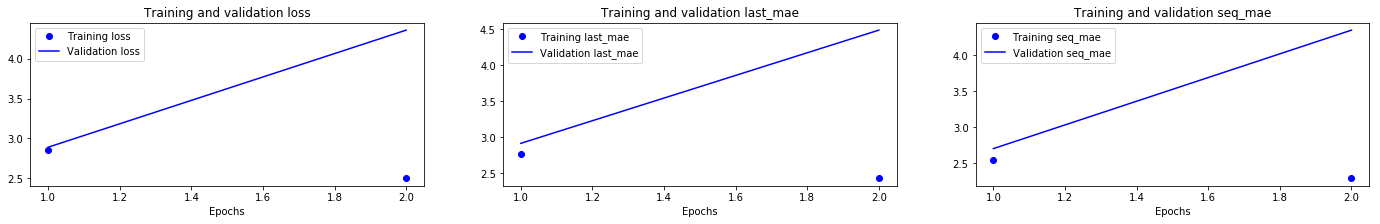

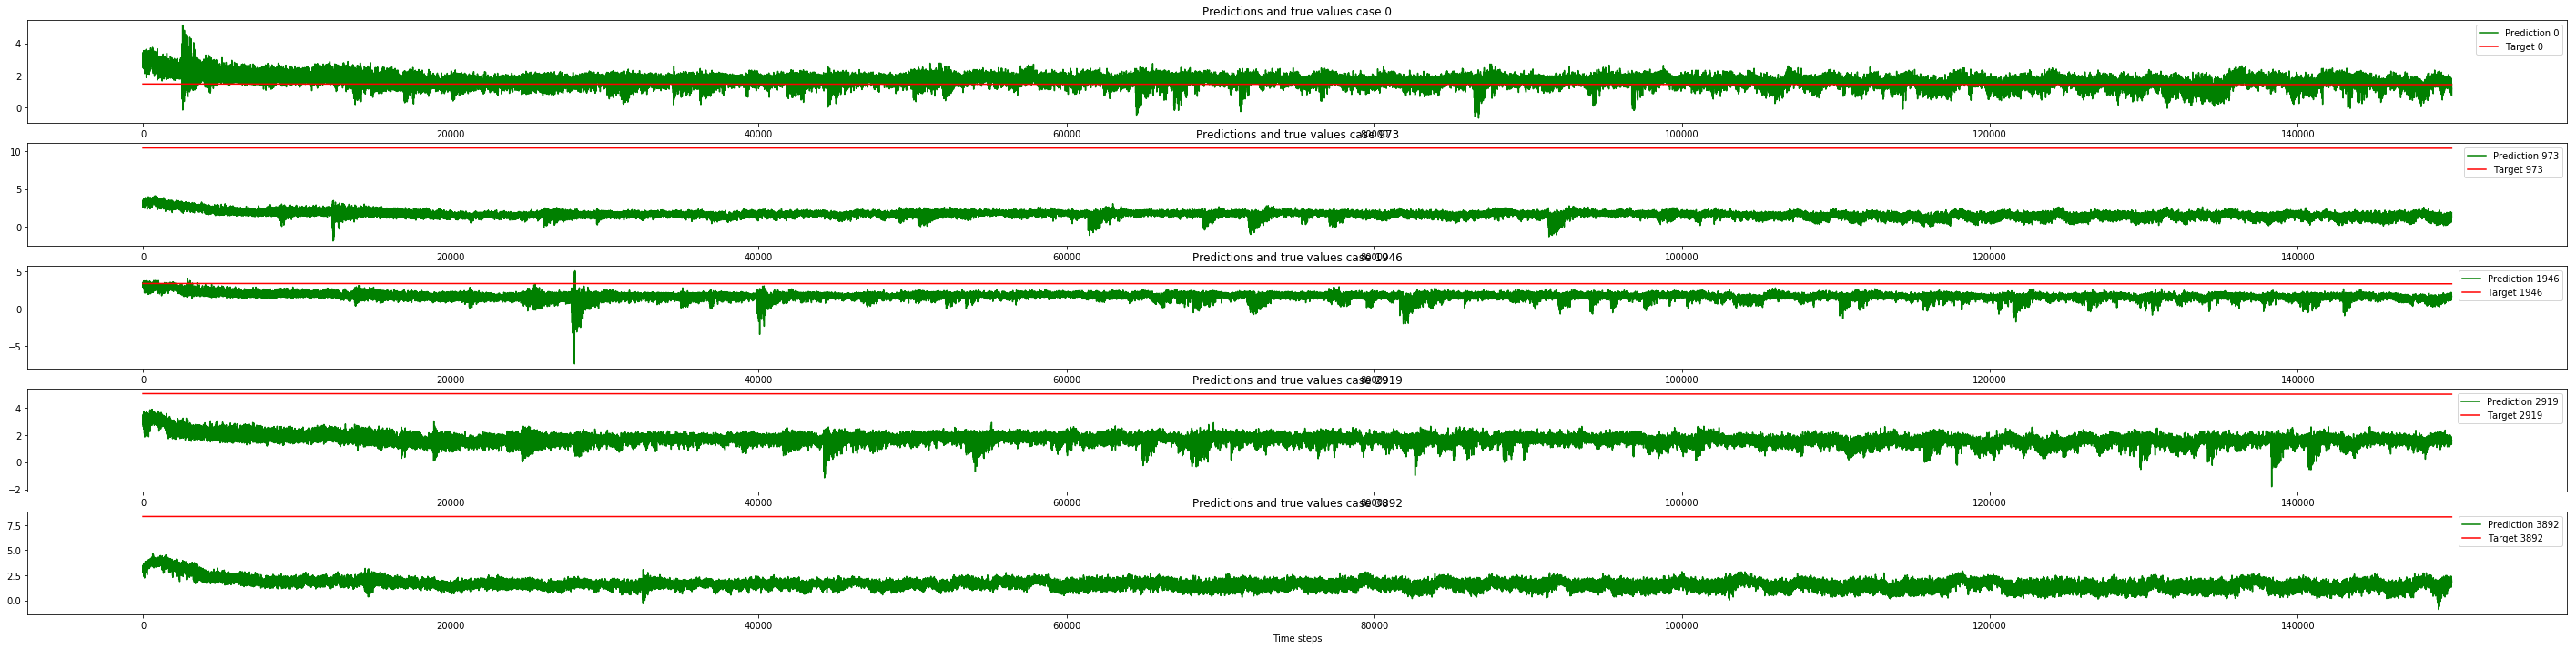

100%|██████████| 4151/4151 [03:37<00:00, 19.05it/s]


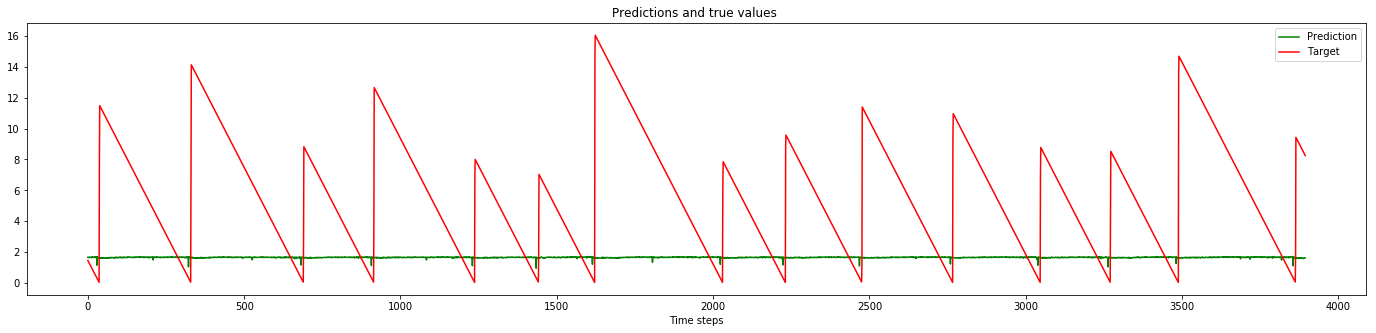

In [10]:
%matplotlib inline
# Visualize accuracies
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 3))

for i, what in enumerate(['loss', 'last_mae', 'seq_mae']):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.subplot(1, 3, i+1)
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()

plt.show()

plot_case_count = 4
plt.figure(figsize=(50, 3*plot_case_count))
for i, case in enumerate(range(0, total_cases-withheld_cases, (total_cases-withheld_cases)//plot_case_count)):
    start = case * case_size
    end = start + seg_size
    seg = data[start:end]
    features = augment_data(seg)
    features = np.expand_dims(features, axis=0)
    predict = np.squeeze(model.predict(features))
    target_values = np.squeeze(seg.time_to_failure.values)

    plt.subplot(plot_case_count+1, 1, i+1)
    plt.plot(predict, color='g', label = "Prediction " + str(case))
    plt.plot(target_values, color='red', label = "Target " + str(case))
    plt.title("Predictions and true values case " + str(case))
    plt.xlabel("Time steps")
    plt.legend()
    
plt.show()

predictions = []
targets = []
for case in tqdm(range(total_cases)):
    start = case * case_size
    end = start + seg_size
    seg = data[start:end]
    if seg.shape[0] == seg_size:
        features = augment_data(seg)
        features = np.expand_dims(features, axis=0)
        predict = model.predict(features).mean()
        predictions.append(predict)
        targets.append(seg.time_to_failure.values.mean())
predictions = np.asarray(predictions)
target_values = np.asarray(targets)

plt.figure(figsize=(24, 5))
plt.plot(predictions, color='g', label = "Prediction")
plt.plot(target_values, color='red', label = "Target")
plt.title("Predictions and true values ")
plt.xlabel("Time steps")
plt.legend()
plt.show()

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm(submission.index, total=submission.shape[0])):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv', dtype={'acoustic_data': np.float32})
    features = augment_data(seg)
    features = np.expand_dims(features, axis=0)
    predict = model.predict(features).mean(axis=1) - 0.01875
    submission.time_to_failure[i] = predict

# Save
submission.to_csv('submission.csv')

submission.head()
